# Projekt Analityczny PySpark

## Wprowadzenie

W tym projekcie przeprowadzę kompleksową analizę datasetu. Celem projektu jest zastosowanie technik PySpark poznanych podczas zajęć do rozwiązania rzeczywistych problemów analitycznych.

## Konfiguracja środowiska

In [ ]:
# Instalacja i konfiguracja PySpark
!pip install pyspark==3.5.5

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import *

# Tworzenie sesji Spark
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Projekt PySpark") \
    .getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.2/317.2 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.5-py2.py3-none-any.whl size=317747862 sha256=7165db0208d17aa4319131a95fbb75e8644a12a3e19f1b669db9f56dabcd284d
  Stored in directory: /root/.cache/pip/wheels/0c/7f/b4/0e68c6d8d89d2e582e5498ad88616c16d7c19028680e9d3840
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1


## Zadanie 1: Wczytanie własnego datasetu

Wczytaj swój dataset do PySpark DataFrame. Dostosuj format i opcje wczytywania do specyfiki Twojego zbioru danych.

In [ ]:
# Wczytanie datasetu
df = spark.read.csv("Advanced.csv", header=True, inferSchema=True)

# Wyświetlanie podstawowych informacji o datasecie
df.printSchema()
df.show(5)

root
 |-- seas_id: string (nullable = true)
 |-- season: integer (nullable = true)
 |-- player_id: string (nullable = true)
 |-- player: string (nullable = true)
 |-- birth_year: string (nullable = true)
 |-- pos: string (nullable = true)
 |-- age: string (nullable = true)
 |-- experience: string (nullable = true)
 |-- lg: string (nullable = true)
 |-- tm: string (nullable = true)
 |-- g: integer (nullable = true)
 |-- mp: string (nullable = true)
 |-- per: string (nullable = true)
 |-- ts_percent: string (nullable = true)
 |-- x3p_ar: string (nullable = true)
 |-- f_tr: string (nullable = true)
 |-- orb_percent: string (nullable = true)
 |-- drb_percent: string (nullable = true)
 |-- trb_percent: string (nullable = true)
 |-- ast_percent: string (nullable = true)
 |-- stl_percent: string (nullable = true)
 |-- blk_percent: string (nullable = true)
 |-- tov_percent: string (nullable = true)
 |-- usg_percent: string (nullable = true)
 |-- ows: string (nullable = true)
 |-- dws: string (

## Zadanie 2: Preprocessing danych

Przeprowadź kompleksowy preprocessing danych, dostosowany do specyfiki Twojego datasetu.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType, IntegerType, NumericType
from pyspark.sql.window import Window
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.functions import vector_to_array
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable

# Custom transformer: ColumnScaler
class ColumnScaler(Transformer, DefaultParamsReadable, DefaultParamsWritable):
    def __init__(self, inputCols):
        super(ColumnScaler, self).__init__()
        self.inputCols = inputCols

    def _transform(self, df):
        stats = df.select(
            [avg(col(c)).alias(f"{c}_mean") for c in self.inputCols] +
            [stddev(col(c)).alias(f"{c}_std") for c in self.inputCols]
        ).first()
        for c in self.inputCols:
            mean_c = stats[f"{c}_mean"]
            std_c = stats[f"{c}_std"] if stats[f"{c}_std"] != 0 else 1.0
            df = df.withColumn(f"{c}_scaled", (col(c) - mean_c) / std_c)
        return df

# Custom transformer: FeatureEngineer
class FeatureEngineer(Transformer, DefaultParamsReadable, DefaultParamsWritable):
    def _transform(self, df):
        if "age_scaled" in df.columns:
            df = df.withColumn("age_squared", col("age_scaled") ** 2)
        if "mp_scaled" in df.columns and "g_scaled" in df.columns:
            df = df.withColumn("minutes_eff", col("mp_scaled") / (col("g_scaled") + lit(1)))
        if "ows_scaled" in df.columns and "mp_scaled" in df.columns:
            df = df.withColumn("off_rating", col("ows_scaled") / (col("mp_scaled") + lit(1)))
        if "ws_scaled" in df.columns:
            df = df.withColumn("career_avg_ws", avg("ws_scaled").over(Window.partitionBy("player")))
        return df

# 2.1 Analiza jakości danych
print("Dane: konwersja typów numerycznych")
to_cast = [
    "age", "experience", "mp", "per", "ts_percent", "x3p_ar", "f_tr", "orb_percent",
    "drb_percent", "trb_percent", "ast_percent", "stl_percent", "blk_percent",
    "tov_percent", "usg_percent", "ows", "dws", "ws", "ws_48", "obpm", "dbpm",
    "bpm", "vorp"
]
for col_name in to_cast:
    if col_name in df.columns:
        df = df.withColumn(col_name, col(col_name).cast(DoubleType()))

total_count = df.count()

print("Zliczanie braków danych")
missing_df = df.select([
    count(when(col(c).isNull() | isnan(col(c)) | (col(c) == "NA"), c)).alias(f"{c}_missing") for c in df.columns
])
print("Procent braków danych")
missing_pct_df = missing_df.select([
    (col(c) / total_count * 100).alias(c.replace("_missing", "_missing_pct")) for c in missing_df.columns
])

missing_df.show(5)
missing_pct_df.show(5)

print("Duplikaty (całe wiersze):", df.count() - df.dropDuplicates().count())
print("Duplikaty (player, season, tm):", df.count() - df.dropDuplicates(["player", "season", "tm"]).count())

print("Z-score dla kolumny 'per'")
stats = df.select(mean("per"), stddev("per")).first()
mean_val, std_val = stats[0], stats[1]
df.select("player", "per", ((col("per") - mean_val) / std_val).alias("z_score")).show()

print("Niespójności: sezony większe niż 2025")
df.filter(col("season") > 2025).show()

non_negative_cols = ["age", "experience", "g", "mp"]

print("Niespójności: wartości ujemne w logicznie dodatnich kolumnach")
for nc in non_negative_cols:
    if nc in df.columns:
        neg_count = df.filter(col(nc) < 0).count()
        if neg_count > 0:
            df.filter(col(nc) < 0).select("player", "season", nc).show(1)


# 2.2 Czyszczenie danych
print("Uzupełnianie danych dla konkretnych graczy")
df = df.withColumn(
    "pos",
    when((col("player") == "Phillip Wheeler") & col("pos").isNull(), "SF")
    .when((col("player") == "Tyson Etienne") & col("pos").isNull(), "PG")
    .otherwise(col("pos"))
)
df = df.withColumn(
    "birth_year",
    when((col("player") == "Phillip Wheeler") & col("birth_year").isNull(), 2001)
    .when((col("player") == "Tyson Etienne") & col("birth_year").isNull(), 1999)
    .otherwise(col("birth_year"))
)
df = df.withColumn(
    "experience",
    when((col("player") == "Phillip Wheeler") & col("experience").isNull(), 0)
    .when((col("player") == "Tyson Etienne") & col("experience").isNull(), 1)
    .otherwise(col("experience"))
)
df = df.drop("birth_year")

print("Usuwanie kolumn z więcej niż 40% braków")
to_drop = [k.replace("_missing", "") for k, v in missing_df.collect()[0].asDict().items() if v / total_count > 0.4]
df = df.drop(*to_drop)

numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, (DoubleType, IntegerType))]
print("Imputacja średnią")
for col_name in numeric_cols:
    if col_name != "season" and col_name in df.columns:
        mean_val = df.select(avg(col_name)).first()[0]
        df = df.withColumn(col_name, when(isnull(col(col_name)), mean_val).otherwise(col(col_name)))

print("Usunięcie duplikatów logicznych")
df = df.dropDuplicates(["player", "season", "tm"])

print("Usunięcie wartości odstających (IQR)")
for col_name in ["per", "ws", "ts_percent"]:
    if col_name in df.columns:
        q1, q3 = df.approxQuantile(col_name, [0.25, 0.75], 0.05)
        iqr = q3 - q1
        df = df.filter((col(col_name) >= q1 - 1.5 * iqr) & (col(col_name) <= q3 + 1.5 * iqr))

print("Czyszczenie nazw graczy")
if "player" in df.columns:
    df = df.withColumn("player", lower(trim(col("player"))))

df_cleaned = df.filter(
    (col("seas_id").isNotNull()) & (~isnan(col("seas_id"))) & (col("seas_id") != "NA")
)

# 2.3 i 2.4 Transformacja danych: kodowanie i skalowanie oraz inżyniera cech w pipeline
print("Tworzenie pipeline dla kodowania i skalowania")

numerics_to_scale = [c for c in numeric_cols if c in df_cleaned.columns and c != "season"]
new_features = ["age_squared", "minutes_eff", "off_rating", "career_avg_ws"]

tm_indexer = StringIndexer(inputCol="tm", outputCol="tm_index", handleInvalid="keep")
tm_encoder = OneHotEncoder(inputCol="tm_index", outputCol="tm_vec")
pos_indexer = StringIndexer(inputCol="pos", outputCol="pos_index", handleInvalid="keep")
pos_encoder = OneHotEncoder(inputCol="pos_index", outputCol="pos_vec")

scaler = ColumnScaler(inputCols=numerics_to_scale)
feature_engineer = FeatureEngineer()
final_scaler = ColumnScaler(inputCols=new_features)

pipeline = Pipeline(stages=[
    tm_indexer,
    tm_encoder,
    pos_indexer,
    pos_encoder,
    scaler,
    feature_engineer,
    final_scaler
])

pipeline_model = pipeline.fit(df_cleaned)
df_cleaned = pipeline_model.transform(df_cleaned)

# 2.5 Finalizacja preprocessingu
print("Sprawdzanie braków po przetwarzaniu")
checkable_cols = [f.name for f in df_cleaned.schema.fields if not isinstance(f.dataType, VectorUDT)]
total_rows = df_cleaned.count()
missing_counts = {}
for c in checkable_cols:
    dtype = df_cleaned.schema[c].dataType
    condition = col(c).isNull() | (col(c) == "NA")
    if isinstance(dtype, NumericType):
        condition = condition | isnan(col(c))
    count_val = df_cleaned.filter(condition).count()
    if count_val > 0:
        missing_counts[c] = count_val

if missing_counts:
    print("Kolumny z brakującymi wartościami po przetwarzaniu:")
    for col_name, count_val in missing_counts.items():
        pct = (count_val / total_rows) * 100
        print(f"{col_name}: {count_val} braków ({pct:.2f}%)")
else:
    print("Brak brakujących wartości po przetwarzaniu danych.")

print("Dane po przetwarzaniu")
df_cleaned.show(5, truncate=False)


Dane: konwersja typów numerycznych
Zliczanie braków danych
Procent braków danych
+---------------+--------------+-----------------+--------------+------------------+-----------+-----------+------------------+----------+----------+---------+----------+-----------+------------------+--------------+------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+----------+-------------+------------+------------+-----------+------------+
|seas_id_missing|season_missing|player_id_missing|player_missing|birth_year_missing|pos_missing|age_missing|experience_missing|lg_missing|tm_missing|g_missing|mp_missing|per_missing|ts_percent_missing|x3p_ar_missing|f_tr_missing|orb_percent_missing|drb_percent_missing|trb_percent_missing|ast_percent_missing|stl_percent_missing|blk_percent_missing|tov_percent_missing|usg_percent_missing|ows_missing|dws_missing|ws_missing|ws_48

## Zadanie 3: Eksploracyjna analiza danych (EDA)

Przeprowadź eksploracyjną analizę danych, aby lepiej zrozumieć strukturę i charakterystykę Twojego datasetu.

+-------+-----------------+------------------+-----------------+--------------+-----+------------------+-----------------+-----+-----+------------------+------------------+------------------+-------------------+-------------------+------------------+-----------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------

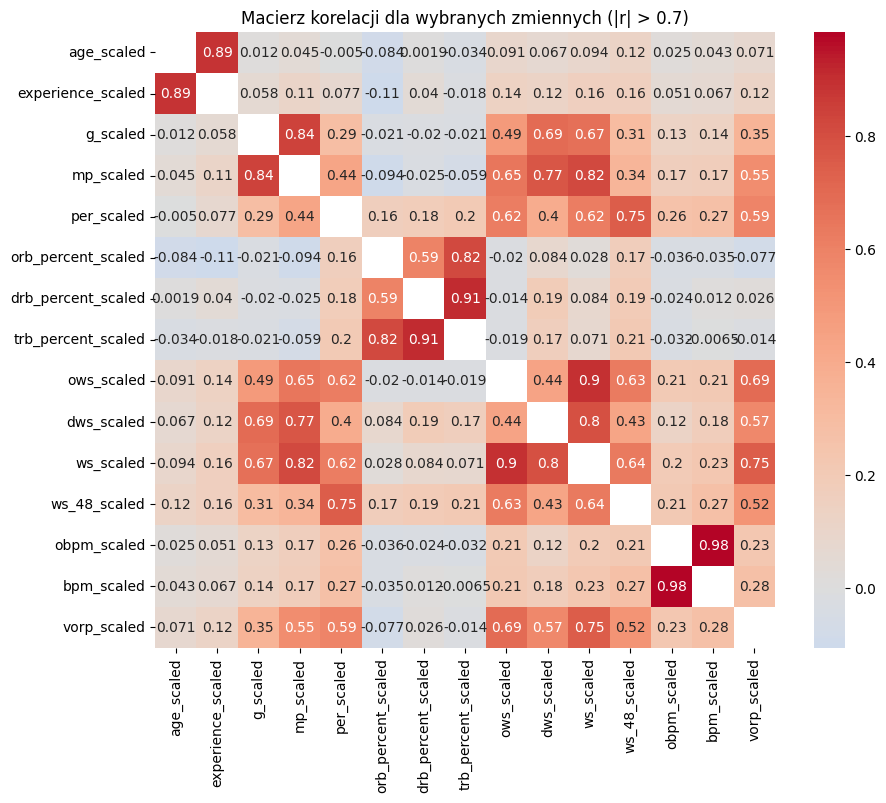

Średnie statystyki wg pozycji (pos):
+-----+------------------+------------------+-------------------+-------------------+-------------------+------------------+
|pos  |per_avg           |ws_avg            |ts_percent_avg     |bpm_avg            |vorp_avg           |mp_avg            |
+-----+------------------+------------------+-------------------+-------------------+-------------------+------------------+
|C    |12.948469775305911|1.9988817560571515|0.5137304797186698 |-2.2381692415230776|0.2439831749200253 |1024.174997443515 |
|C-F  |12.661632662488227|1.6221302719626745|0.40770193059929843|-1.9003154925395214|0.5398485635810067 |1006.655850833607 |
|C-PF |12.951282051282051|1.9923076923076923|0.5122820512820513 |-2.033381870647106 |0.2702331123457959 |1037.5384615384614|
|C-SF |12.0              |2.3               |0.523              |-1.3               |0.2                |967.0             |
|F    |11.559457593984938|0.6111378980440135|0.41585840707964605|-1.9003154925395203|0.5

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import skewness, kurtosis, min, max
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import round as spark_round

# 3.1 Statystyki opisowe
# Kod statystyk opisowych
df_cleaned.summary().show()
df_cleaned.select([F.variance(c).alias(c) for c in df_cleaned.columns if "scaled" in c]).show()

# 3.2 Analiza rozkładów
# Kod analizy rozkładów
for col_name in [c for c in df_cleaned.columns if "scaled" in c]:
    df_cleaned.select(
        min(col_name).alias("min"),
        max(col_name).alias("max"),
        skewness(col_name).alias("skewness"),
        kurtosis(col_name).alias("kurtosis")
    ).show()

# 3.3 Analiza korelacji
# Kod analizy korelacji
scaled_cols = [c for c in df_cleaned.columns if "scaled" in c]
assembler = VectorAssembler(inputCols=scaled_cols, outputCol="features_vec")
df_corr = assembler.transform(df_cleaned).select("features_vec")

correlation_matrix = Correlation.corr(df_corr, "features_vec", method="pearson").head()[0]
corr_array = correlation_matrix.toArray()
np.fill_diagonal(corr_array, np.nan)

corr_df = pd.DataFrame(corr_array, columns=scaled_cols, index=scaled_cols)

# Filtrujemy tylko silne korelacje
high_corr = (np.abs(corr_df) > 0.7)
important_cols = high_corr.any()[high_corr.any()].index.tolist()

filtered_corr_df = corr_df.loc[important_cols, important_cols]

# Wizualizacja
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr_df, annot=True, cmap="coolwarm", center=0)
plt.title("Macierz korelacji dla wybranych zmiennych (|r| > 0.7)")
plt.show()


# 3.4 Analiza grupowa

# Zbadamy metryki wg doświadczenia, klubu oraz pozycji
# Kod analizy grupowej
df_grouped = df_cleaned.withColumn(
    "experience_group",
    when(col("experience") == 0, "rookie")
    .when(col("experience") == 1, "sophomore")
    .when(col("experience") <= 3, "young")
    .when(col("experience") <= 7, "prime")
    .otherwise("veteran")
)

metrics = ["per", "ws", "ts_percent", "bpm", "vorp", "mp"]
metrics = [m for m in metrics if m in df_grouped.columns]

# 1. Średnie statystyki wg pozycji
print("Średnie statystyki wg pozycji (pos):")
df_grouped.groupBy("pos").agg(
    *[avg(col(m)).alias(f"{m}_avg") for m in metrics]
).orderBy("pos").show(truncate=False)

# 2. Średnie metryki wg drużyny (tm)
print("Statystyki wg drużyny:")
df_grouped.groupBy("tm").agg(
    count("*").alias("player_count"),
    *[avg(col(m)).alias(f"{m}_avg") for m in metrics]
).orderBy(col("per_avg").desc()).show(truncate=False)

# 3. Średnie metryki wg doświadczenia
print("Średnie metryki wg grup doświadczenia:")
df_grouped.groupBy("experience_group") \
    .agg(*[spark_round(avg(col(m)), 3).alias(f"avg_{m}") for m in metrics]) \
    .orderBy("experience_group") \
    .show()



## Zadanie 4: Analiza trendów i wzorców czasowych

Przeprowadź analizę trendów i wzorców czasowych.

In [ ]:
from pyspark.sql.functions import avg
# 4.1 Przygotowanie danych czasowych

# Kod przygotowania danych czasowych

# 4.2 Analiza trendów

# Średnie sezonowe dla kluczowych metryk
metrics = ["per_scaled", "ws_scaled", "ts_percent_scaled"]
df_trend = df_cleaned.groupBy("season").agg(*[
    avg(col(m)).alias(f"{m}_avg") for m in metrics if m in df_cleaned.columns
]).orderBy("season")

df_trend.show(80, truncate = False)


# 4.3 Analiza sezonowości

# Kod analizy sezonowości
window_spec = Window.orderBy("season")

# Zmiany między sezonami
df_trend = df_trend.withColumn("prev_ws", lag("ws_scaled_avg").over(window_spec)) \
                   .withColumn("ws_yoy_change", (col("ws_scaled_avg") - col("prev_ws")) / col("prev_ws") * 100)

df_trend.show(80,truncate = False)
# 4.4 Analiza zmian rok do roku / miesiąc do miesiąca

# Kod analizy zmian

df_trend = df_trend.withColumn("prev_per", lag("per_scaled_avg").over(window_spec)) \
                   .withColumn("per_yoy_change", (col("per_scaled_avg") - col("prev_per")) / col("prev_per") * 100)

df_trend = df_trend.withColumn("prev_ts", lag("ts_percent_scaled_avg").over(window_spec)) \
                   .withColumn("ts_yoy_change", (col("ts_percent_scaled_avg") - col("prev_ts")) / col("prev_ts") * 100)

df_trend.select("season", "ws_yoy_change", "per_yoy_change", "ts_yoy_change").show(80,truncate = False)

+------+---------------------+----------------------+---------------------+
|season|per_scaled_avg       |ws_scaled_avg         |ts_percent_scaled_avg|
+------+---------------------+----------------------+---------------------+
|1947  |0.008909437522503595 |0.1873297026726998    |-2.026999379481008   |
|1948  |0.008909437522503592 |0.6234634708502578    |-2.07867306284046    |
|1949  |0.00890943752250361  |0.10701521735109534   |-1.6441638702252668  |
|1950  |0.008909437522503613 |0.13470158968545404   |-1.5947408036429802  |
|1951  |0.008909437522503609 |-0.06267393362286741  |-1.53357326726898    |
|1952  |0.19770591781276975  |0.1735281341709859    |-1.3373432598352917  |
|1953  |0.10068024963770214  |0.058765443859492714  |-1.279461074629175   |
|1954  |0.15455574016089557  |0.09114543134380072   |-1.2965914070374223  |
|1955  |-0.021224609190168824|0.12151013954057914   |-1.26402109246636    |
|1956  |0.05112774381944744  |0.17438784328659548   |-1.1311639464941876  |
|1957  |-0.0

## Zadanie 5: Segmentacja i klasyfikacja

Przeprowadź segmentację lub klasyfikację obiektów w Twoim datasecie na podstawie wybranych kryteriów.

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
# 5.1 Definicja kryteriów segmentacji/klasyfikacji

# Kod definicji kryteriów
def classify_player(per, ws, exp):
    if exp is None or per is None or ws is None:
        return "unknown"
    if exp <= 1:
        return "rookie"
    elif per >= 1.0 and ws >= 1.0:
        return "star"
    else:
        return "role_player"

# 5.2 Implementacja funkcji klasyfikującej (UDF)

# Kod implementacji UDF
segment_udf = udf(classify_player, StringType())
# 5.3 Zastosowanie segmentacji/klasyfikacji

# Kod zastosowania segmentacji
df_segmented = df_cleaned.withColumn(
    "player_segment",
    segment_udf(
        col("per_scaled"), col("ws_scaled"), col("experience")
    )
)

df_segmented.select("player", "experience", "per_scaled", "ws_scaled", "player_segment").show(80, truncate=False)


# 5.4 Analiza charakterystyk segmentów

# Kod analizy segmentów
df_segmented.groupBy("player_segment").agg(
    count("*").alias("count"),
    avg("per_scaled").alias("avg_per_scaled"),
    avg("ws_scaled").alias("avg_ws_scaled"),
    avg("experience").alias("avg_experience")
).orderBy("count", ascending=False).show(80, truncate = False)


+--------------+----------+---------------------+----------------------+--------------+
|player        |experience|per_scaled           |ws_scaled             |player_segment|
+--------------+----------+---------------------+----------------------+--------------+
|a.c. green    |1.0       |-0.18462578898839002 |0.7075717705916155    |rookie        |
|a.c. green    |6.0       |0.3734846152097562   |2.1348641298389       |role_player   |
|a.c. green    |10.0      |0.48510669604938506  |2.440712492534747     |role_player   |
|a.c. green    |11.0      |0.1223349333205903   |1.2682937688673348    |role_player   |
|a.c. green    |12.0      |0.038618372690868166 |1.0643948604034368    |role_player   |
|a.c. green    |12.0      |-0.24043682940820493 |-0.5667964073077458   |role_player   |
|a.c. green    |12.0      |-0.017192667728946256|1.4721926773312324    |role_player   |
|a.c. green    |13.0      |0.09442941311068309  |1.6760915857951304    |role_player   |
|a.c. green    |14.0      |0.010

## Zadanie 6: Analiza z wykorzystaniem funkcji okienkowych

Wykorzystaj funkcje okienkowe do zaawansowanej analizy danych w kontekście.

In [ ]:
from pyspark.sql.functions import percent_rank, rank
from pyspark.sql.functions import lag
from pyspark.sql.functions import avg, sum as spark_sum
# 6.1 Ranking i percentyle

# Kod rankingu i percentyli
ranking_window = Window.partitionBy("season").orderBy(col("ws_scaled").desc())

df_ranked = df_segmented.withColumn("ws_rank", rank().over(ranking_window)) \
                        .withColumn("ws_percentile", percent_rank().over(ranking_window))

df_ranked.select("player", "season", "ws_scaled", "ws_rank", "ws_percentile").show(10, truncate=False)
# 6.2 Analiza sekwencyjna

# Kod analizy sekwencyjnej
seq_window = Window.partitionBy("player").orderBy("season")

df_seq = df_ranked.withColumn("prev_ws", lag("ws_scaled", 1).over(seq_window)) \
                  .withColumn("ws_diff", col("ws_scaled") - col("prev_ws"))

df_seq.select("player", "season", "ws_scaled", "prev_ws", "ws_diff").show(10)

# 6.3 Sumy i średnie ruchome

# Kod sum i średnich ruchomych

moving_avg_window = Window.partitionBy("player").orderBy("season").rowsBetween(-2, 0)

df_ma = df_seq.withColumn("ws_3season_avg", avg("ws_scaled").over(moving_avg_window)) \
              .withColumn("ws_3season_sum", spark_sum("ws_scaled").over(moving_avg_window))

df_ma.select("player", "season", "ws_scaled", "ws_3season_avg", "ws_3season_sum").show(10)

# 6.4 Analiza YTD (Year-to-Date) / MTD (Month-to-Date)

# Kod analizy YTD/MTD
ytd_window = Window.partitionBy("player", "season").orderBy("g").rowsBetween(Window.unboundedPreceding, 0)

df_ytd = df_cleaned.withColumn("mp_ytd", spark_sum("mp").over(ytd_window))

+---------------+------+------------------+-------+--------------------+
|player         |season|ws_scaled         |ws_rank|ws_percentile       |
+---------------+------+------------------+-------+--------------------+
|earl shannon   |1947  |2.5936366738826706|1      |0.0                 |
|connie simmons |1947  |2.1348641298389   |2      |0.030303030303030304|
|art hillhouse  |1947  |1.7780410400270794|3      |0.06060606060606061 |
|kenny sailors  |1947  |1.6760915857951304|4      |0.09090909090909091 |
|leo mogus      |1947  |1.6251168586791556|5      |0.12121212121212122 |
|hank rosenstein|1947  |1.3702432230992834|6      |0.15151515151515152 |
|tony jaros     |1947  |1.2682937688673348|7      |0.18181818181818182 |
|bud palmer     |1947  |1.0134201332874622|8      |0.21212121212121213 |
|cecil hankins  |1947  |0.9624454061714877|9      |0.24242424242424243 |
|harry zeller   |1947  |0.9114706790555134|10     |0.2727272727272727  |
+---------------+------+------------------+-------+

## Zadanie 7: Analiza asocjacji i współwystępowania

Przeprowadź analizę asocjacji i współwystępowania obiektów/zdarzeń w Twoim datasecie.

In [ ]:
import itertools
# 7.1 Przygotowanie danych do analizy asocjacji
# Kod przygotowania danych
transactions_df = df_cleaned.groupBy("season", "tm").agg(
    collect_set("player").alias("items")
)

# 7.2 Analiza częstości współwystępowania
# Kod analizy współwystępowania
def generate_pairs(items):
    return list(itertools.combinations(sorted(items), 2))

generate_pairs_udf = udf(generate_pairs, ArrayType(StructType([
    StructField("itemA", StringType()),
    StructField("itemB", StringType())
])))

# Alternatywnie: wypłaszczenie przez explode i eksploracja ręcznie
pairs_df = transactions_df.withColumn("pair", explode(generate_pairs_udf("items"))) \
    .selectExpr("pair.itemA as itemA", "pair.itemB as itemB")

# Licz częstotliwość par
pair_freq_df = pairs_df.groupBy("itemA", "itemB").count().alias("pair_count")

# Licz pojedyncze wystąpienia
item_freq_df = transactions_df.withColumn("item", explode("items")) \
    .groupBy("item").count().alias("item_count")

# 7.3 Obliczenie miar asocjacji

# Kod obliczenia miar asocjacji

num_transactions = transactions_df.count()

# Oblicz wsparcie (support)
support_df = pair_freq_df.withColumn("support", col("count") / num_transactions)

# Dołącz dane o częstości pojedynczych itemów (dla confidence i lift)
assoc_df = support_df \
    .join(item_freq_df.withColumnRenamed("item", "itemA").withColumnRenamed("count", "countA"), on="itemA") \
    .join(item_freq_df.withColumnRenamed("item", "itemB").withColumnRenamed("count", "countB"), on="itemB")

# Confidence: P(B|A) = count(A ∩ B) / count(A)
# Lift: P(B|A) / P(B) = confidence / (count(B) / total)
assoc_df = assoc_df.withColumn("confidence", col("count") / col("countA")) \
                   .withColumn("lift", (col("confidence")) / (col("countB") / num_transactions))

# 7.4 Identyfikacja najsilniejszych reguł
# Kod identyfikacji reguł

rules_df = assoc_df.filter(
    (col("support") > 0.001) &
    (col("confidence") > 0.6) &
    (col("lift") > 1.2)
).orderBy(col("lift").desc())

# Wybierz top 20 reguł
top_rules = rules_df.limit(20)
top_rules.show(truncate=False)

+---------------+------------------+-----+---------------------+------+------+----------+-----+
|itemB          |itemA             |count|support              |countA|countB|confidence|lift |
+---------------+------------------+-----+---------------------+------+------+----------+-----+
|samuel robinson|carl fuller       |2    |0.0010718113612004287|2     |2     |1.0       |933.0|
|pat spencer    |brandin podziemski|2    |0.0010718113612004287|2     |2     |1.0       |933.0|
|jarace walker  |ben sheppard      |2    |0.0010718113612004287|2     |2     |1.0       |933.0|
|julian phillips|adama sanogo      |2    |0.0010718113612004287|2     |2     |1.0       |933.0|
|sid tanenbaum  |hal tidrick       |2    |0.0010718113612004287|2     |2     |1.0       |933.0|
|rayan rupert   |duop reath        |2    |0.0010718113612004287|2     |2     |1.0       |933.0|
|pete nance     |alex reese        |2    |0.0010718113612004287|2     |2     |1.0       |933.0|
|arnie johnson  |andy duncan       |2   

In [ ]:
transactions_df.select("items").show(truncate=False)

+---------------------------------------------------------------------------------------------+
|items                                                                                        |
+---------------------------------------------------------------------------------------------+
|[hal crisler, harold kottman, jerry kelly, connie simmons, bob duffy]                        |
|[tony jaros]                                                                                 |
|[leo mogus, kenny sailors, ken corley]                                                       |
|[john murphy, frido frey, bud palmer, jake weber, hank rosenstein]                           |
|[ralph kaplowitz, art hillhouse]                                                             |
|[harry zeller, walt miller, john mills]                                                      |
|[woody grimshaw, elmore morgenthaler, earl shannon, red dehnert, jake weber, hank rosenstein]|
|[cecil hankins, belus smawley]         

## Zadanie 8: Analiza anomalii i wartości odstających

Zidentyfikuj i przeanalizuj anomalie i wartości odstające w Twoim datasecie.

In [ ]:
from builtins import round as python_round
from pyspark.sql.functions import col, lit
from pyspark.sql import functions as F

# 8.1 Definicja parametrów
target_col = "mp"
z_threshold = 3

print("8.2.1 Obliczanie statystyk do Z-score...")
stats = df_cleaned.select(
    F.mean(target_col).alias("mean_val"),
    F.stddev(target_col).alias("std_val")
).first()

mean_val = stats["mean_val"]
std_val = stats["std_val"] if stats["std_val"] != 0 else 1.0
print(f"Średnia: {mean_val:.2f}, Odchylenie standardowe: {std_val:.2f}")

print("8.2.2 Obliczanie Z-score i flagowanie anomalii...")
df_zscore = df_cleaned.withColumn(
    "z_score", (col(target_col) - mean_val) / std_val
).withColumn(
    "is_anomaly_z", F.when(F.abs(col("z_score")) > z_threshold, 1).otherwise(0)
)

print("8.2.3 Obliczanie IQR i flagowanie anomalii...")
q1, q3 = df_cleaned.approxQuantile(target_col, [0.25, 0.75], 0.01)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
print(f"Q1: {q1}, Q3: {q3}, IQR: {iqr}, Dolna granica: {lower}, Górna granica: {upper}")

df_iqr = df_zscore.withColumn(
    "is_anomaly_iqr", F.when((col(target_col) < lower) | (col(target_col) > upper), 1).otherwise(0)
)

print("8.2.4 Tworzenie flagi ogólnej...")
df_anomalies = df_iqr.withColumn(
    "is_anomaly", F.when((col("is_anomaly_z") == 1) | (col("is_anomaly_iqr") == 1), 1).otherwise(0)
)

print("8.2.5 Obliczanie liczby anomalii...")
anomaly_count_val = df_anomalies.filter(col("is_anomaly") == 1).count()
total_count_val = df_anomalies.count()
anomaly_ratio_val = python_round(anomaly_count_val / total_count_val * 100, 2)
print(f"Anomalie: {anomaly_count_val} z {total_count_val} obserwacji ({anomaly_ratio_val}%)")

print("8.3 Analiza statystyczna anomalii vs normalne obserwacje:")
df_anomalies.groupBy("is_anomaly").agg(
    F.count(target_col).alias("count"),
    F.mean(target_col).alias("mean"),
    F.expr(f"percentile_approx({target_col}, 0.5)").alias("median"),
    F.min(target_col).alias("min"),
    F.max(target_col).alias("max")
).show()

# 8.4 Rekomendacje
print("8.4.1 Usuwanie anomalii...")
df_cleaned_final = df_anomalies.filter(col("is_anomaly") == 0)

print("8.4.2 Zastępowanie anomalii medianą...")
median_value = df_cleaned.approxQuantile(target_col, [0.5], 0.01)[0]
print(f"Użyta mediana: {median_value}")

df_corrected = df_anomalies.withColumn(
    f"{target_col}_corrected",
    F.when(col("is_anomaly") == 1, lit(median_value)).otherwise(col(target_col))
)

print("8.4.3 Podgląd skorygowanych danych:")
df_corrected.select("player", "season", target_col, f"{target_col}_corrected", "is_anomaly").show(5)




8.2.1 Obliczanie statystyk do Z-score...
Średnia: 1120.31, Odchylenie standardowe: 808.14
8.2.2 Obliczanie Z-score i flagowanie anomalii...
8.2.3 Obliczanie IQR i flagowanie anomalii...
Q1: 391.0, Q3: 1713.0, IQR: 1322.0, Dolna granica: -1592.0, Górna granica: 3696.0
8.2.4 Tworzenie flagi ogólnej...
8.2.5 Obliczanie liczby anomalii...
Anomalie: 5 z 26839 obserwacji (0.02%)
8.3 Analiza statystyczna anomalii vs normalne obserwacje:
+----------+-----+------------------+------+------+------+
|is_anomaly|count|              mean|median|   min|   max|
+----------+-----+------------------+------+------+------+
|         1|    5|            3645.8|3638.0|3558.0|3701.0|
|         0|26834|1119.8373482156462|1016.0|   0.0|3461.0|
+----------+-----+------------------+------+------+------+

8.4.1 Usuwanie anomalii...
8.4.2 Zastępowanie anomalii medianą...
Użyta mediana: 989.0
8.4.3 Podgląd skorygowanych danych:
+----------+------+------+------------+----------+
|    player|season|    mp|mp_correcte

## Zadanie 9: Analiza tekstu

Jeśli Twój dataset zawiera dane tekstowe, przeprowadź analizę tekstu.

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import lower
from pyspark.sql.functions import explode
from pyspark.sql.functions import size
# 9.1 Preprocessing tekstu
# Czyszczenie, tokenizacja, usuwanie stop words, stemming/lemmatyzacja

# Kod preprocessingu tekstu
print(" 9.1 Preprocessing tekstu: czyszczenie i tokenizacja kolumny 'player'...")
df_text = df_cleaned.withColumn("player_lower", lower(col("player")))

tokenizer = Tokenizer(inputCol="player_lower", outputCol="player_tokens")
df_tokenized = tokenizer.transform(df_text)

# Usuwanie stop words (choć w przypadku nazwisk niekonieczne)
remover = StopWordsRemover(inputCol="player_tokens", outputCol="filtered_tokens")
df_filtered = remover.transform(df_tokenized)
print(" Przykładowe tokeny (imiona i nazwiska rozbite na części):")
df_filtered.select("player", "filtered_tokens").show(5, truncate=False)

# 9.2 Analiza częstości słów
# Identyfikacja najczęściej występujących słów/fraz

# Kod analizy częstości
print(" 9.2 Analiza częstości słów: zliczanie najczęstszych tokenów...")
df_words = df_filtered.select(explode(col("filtered_tokens")).alias("word"))
word_freq = df_words.groupBy("word").count().orderBy("count", ascending=False)

print(" Top 10 najczęściej występujących słów (tokenów):")
word_freq.show(10)
# 9.3 Analiza współwystępowania słów
# Identyfikacja słów, które często występują razem

# Kod analizy współwystępowania
print(" 9.3 Analiza współwystępowania słów: sprawdzanie długości nazw (liczby tokenów)...")

# Dodaj kolumnę name_length – liczba tokenów w nazwisku
df_filtered = df_filtered.withColumn("name_length", size("filtered_tokens"))

# Pokaż przykładowe nazwiska, które mają więcej niż jedno słowo
print(" Przykładowe wieloelementowe nazwiska (więcej niż jedno słowo):")
df_filtered.filter(size("filtered_tokens") > 1).select("player", "filtered_tokens").show(5, truncate=False)

# Zgrupuj po liczbie tokenów (czyli długości nazwisk) i policz częstotliwość
print("Liczba słów w nazwiskach graczy:")
df_filtered.groupBy("name_length").count().orderBy("count", ascending=False).show()

# Kod ekstrakcji tematów
print(" 9.4 Ekstrakcja tematów: (uproszczona) analiza najczęściej występujących wzorców w nazwiskach...")
df_filtered = df_filtered.withColumn("name_length", F.size("filtered_tokens"))
df_filtered.groupBy("name_length").count().orderBy("count", ascending=False).show()

print("Brak danych tekstowych z naturalnym językiem – nie można wykonać klasycznej ekstrakcji tematów (LDA).")
print("Zamiast tego zbadano rozkład długości nazw i częstotliwość tokenów.")

 9.1 Preprocessing tekstu: czyszczenie i tokenizacja kolumny 'player'...
 Przykładowe tokeny (imiona i nazwiska rozbite na części):
+----------+---------------+
|player    |filtered_tokens|
+----------+---------------+
|a.c. green|[a.c., green]  |
|a.c. green|[a.c., green]  |
|a.c. green|[a.c., green]  |
|a.c. green|[a.c., green]  |
|a.c. green|[a.c., green]  |
+----------+---------------+
only showing top 5 rows

 9.2 Analiza częstości słów: zliczanie najczęstszych tokenów...
 Top 10 najczęściej występujących słów (tokenów):
+--------+-----+
|    word|count|
+--------+-----+
|williams|  522|
| johnson|  497|
|    john|  466|
|    mike|  419|
|   smith|  365|
|   jones|  336|
|     bob|  321|
|     jim|  316|
|   chris|  306|
|   kevin|  275|
+--------+-----+
only showing top 10 rows

 9.3 Analiza współwystępowania słów: sprawdzanie długości nazw (liczby tokenów)...
 Przykładowe wieloelementowe nazwiska (więcej niż jedno słowo):
+----------+---------------+
|player    |filtered_tokens|

## Zadanie 10: Optymalizacja wydajności

Zastosuj techniki optymalizacji wydajności do swojej analizy.

In [ ]:
import time
# 10.1 Identyfikacja wąskich gardeł
# Kod identyfikacji wąskich gardeł
# Pomiar czasu zliczania najczęstszych słów
start = time.time()

word_freq = df_filtered.select(F.explode("filtered_tokens").alias("word")) \
    .groupBy("word").count().orderBy("count", ascending=False)

word_freq.show(10)

end = time.time()
print(f"Czas wykonania analizy częstości słów: {end - start:.2f} sekundy")

# Analiza planu wykonania
word_freq.explain(True)

start = time.time()
tokenizer = Tokenizer(inputCol="player_lower", outputCol="player_tokens")
df_tokenized = tokenizer.transform(df_text)
df_tokenized.count()  # wymuszenie obliczeń
end = time.time()
print(f"Czas tokenizacji: {end - start:.2f} sekundy")

start = time.time()
remover = StopWordsRemover(inputCol="player_tokens", outputCol="filtered_tokens")
df_filtered = remover.transform(df_tokenized)
df_filtered.count()
end = time.time()
print(f"Czas usuwania stop words: {end - start:.2f} sekundy")

# 10.2 Zastosowanie cachowania
# Kod cachowania
# Przykład: cache'owanie df_filtered, który jest używany wielokrotnie
df_filtered.cache()
df_filtered.count()  # Wymuszenie materializacji

# Alternatywnie:
# df_filtered.persist(StorageLevel.MEMORY_AND_DISK)

# Pomiar czasu po cache'owaniu
start = time.time()

df_filtered = df_filtered.withColumn("name_length", size("filtered_tokens"))
df_filtered.groupBy("name_length").count().show()
end = time.time()
print(f"Czas po cache'owaniu: {end - start:.2f} sekundy")
# 10.3 Optymalizacja partycjonowania
# Kod optymalizacji partycjonowania
# Sprawdzenie liczby partycji
print(f"Liczba partycji: {df_filtered.rdd.getNumPartitions()}")

# Zmiana liczby partycji – np. zmniejszenie dla małego zbioru
df_optimized = df_filtered.coalesce(4)  # lub .repartition(8) dla zwiększenia

# Zastosowanie partitionBy podczas zapisu (jeśli zapisujesz dane)
# df_optimized.write.partitionBy("season").parquet("output_path")

# Pomiar czasu po zmianie partycjonowania
start = time.time()
df_optimized.groupBy("name_length").count().show()
end = time.time()
print(f"Czas po optymalizacji partycjonowania: {end - start:.2f} sekundy")

# 10.4 Porównanie wydajności

# Kod porównania wydajności

def run_version_1(df):
    return df.select(F.explode("filtered_tokens").alias("word")) \
             .groupBy("word").count()

def run_version_2(df):
    return df.rdd.flatMap(lambda row: row.filtered_tokens) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b) \
             .toDF(["word", "count"])

# Wersja 1 (DataFrame API)
start = time.time()
result_v1 = run_version_1(df_filtered)
result_v1.show(5)
print(f"Czas wersji 1 (DataFrame API): {time.time() - start:.2f} sekundy")

# Wersja 2 (RDD API)
start = time.time()
result_v2 = run_version_2(df_filtered)
result_v2.show(5)
print(f"Czas wersji 2 (RDD API): {time.time() - start:.2f} sekundy")

# Rejestracja DataFrame jako tymczasowej tabeli
df_words = df_filtered.select(F.explode("filtered_tokens").alias("word"))
df_words.createOrReplaceTempView("words_view")

# Pomiar czasu dla wersji SQL
start = time.time()

result_v3 = spark.sql("""
    SELECT word, COUNT(*) AS count
    FROM words_view
    GROUP BY word
    ORDER BY count DESC
""")
result_v3.show(5)

print(f"Czas wersji 3 (Spark SQL): {time.time() - start:.2f} sekundy")

+--------+-----+
|    word|count|
+--------+-----+
|williams|  522|
| johnson|  497|
|    john|  466|
|    mike|  419|
|   smith|  365|
|   jones|  336|
|     bob|  321|
|     jim|  316|
|   chris|  306|
|   kevin|  275|
+--------+-----+
only showing top 10 rows

Czas wykonania analizy częstości słów: 2.01 sekundy
== Parsed Logical Plan ==
'Sort ['count DESC NULLS LAST], true
+- Aggregate [word#52647], [word#52647, count(1) AS count#52651L]
   +- Project [word#52647]
      +- Generate explode(filtered_tokens#51692), false, [word#52647]
         +- Project [seas_id#17, season#18, player_id#19, player#4107, pos#2407, age#2726, experience#2771, lg#25, tm#26, g#2815, mp#2859, per#2903, ts_percent#2947, x3p_ar#2991, f_tr#3035, orb_percent#3079, drb_percent#3123, trb_percent#3167, ast_percent#3211, stl_percent#3255, blk_percent#3299, tov_percent#3343, usg_percent#3387, ows#3431, ... 47 more fields]
            +- Project [seas_id#17, season#18, player_id#19, player#4107, pos#2407, age#2726, 

## Zadanie 11: Wizualizacja wyników

Przygotuj wizualizacje kluczowych wyników analizy.

<ipython-input-13-cbf7fdb85d0d>:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=recent_pd, x="season", y="per", estimator="mean", ci=None)


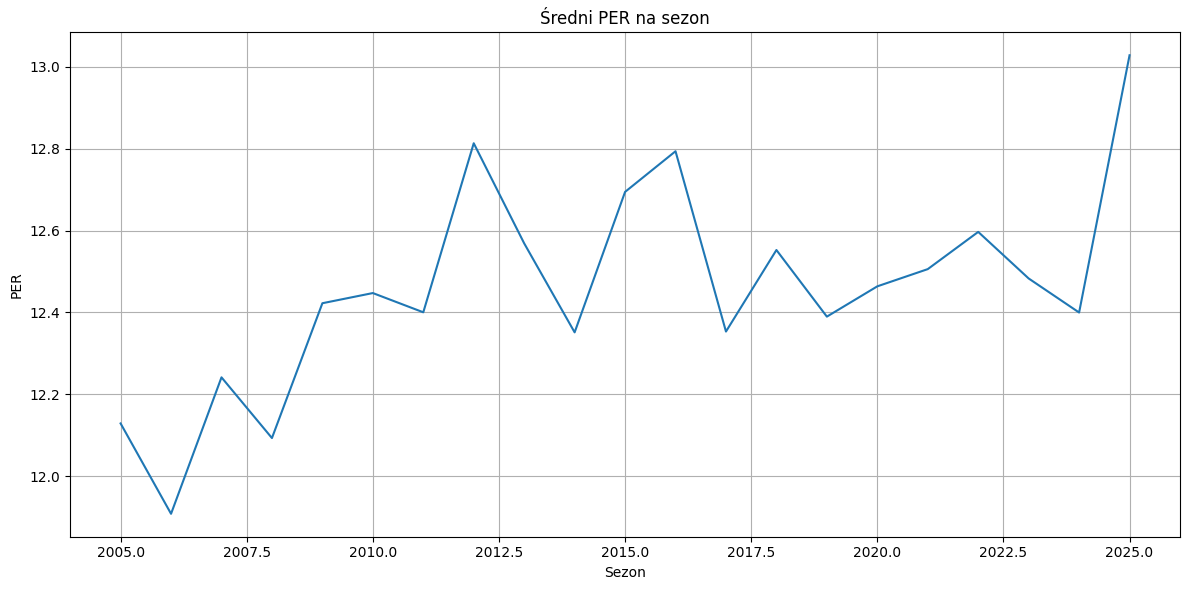

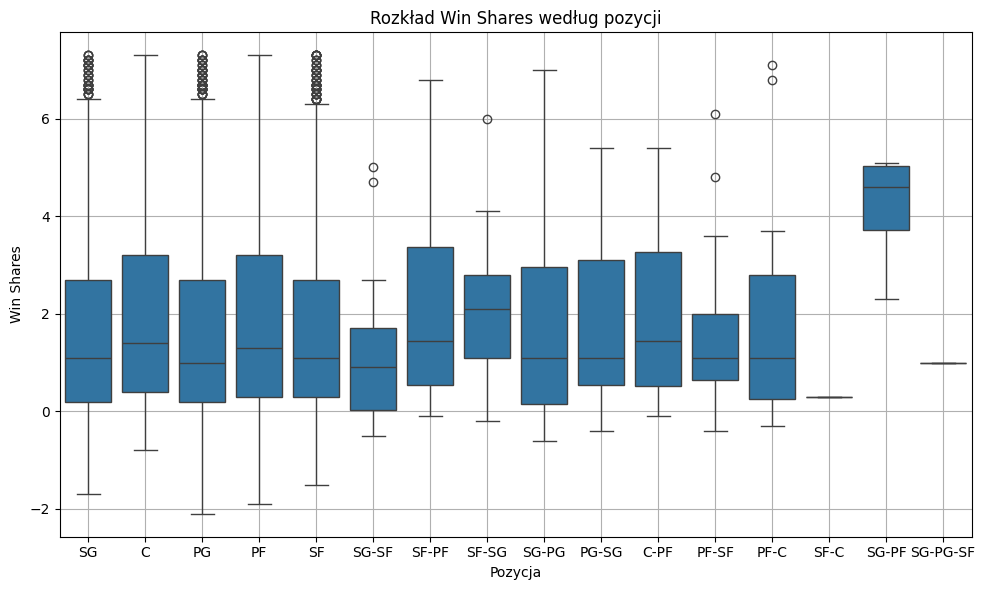

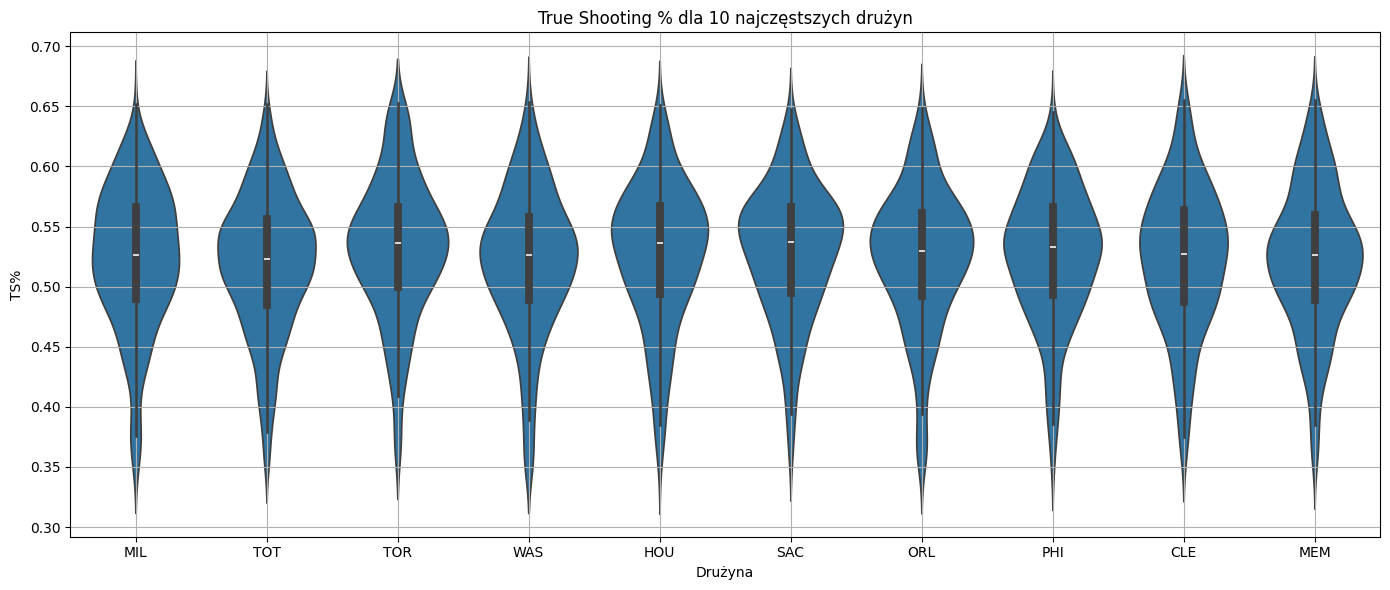

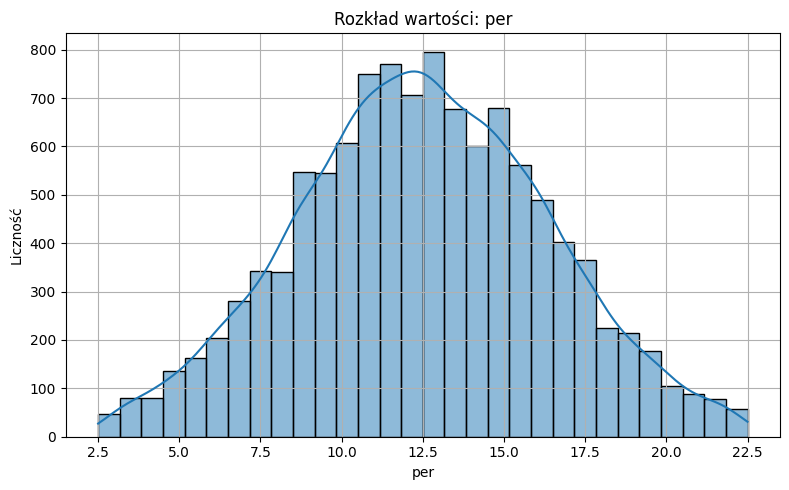

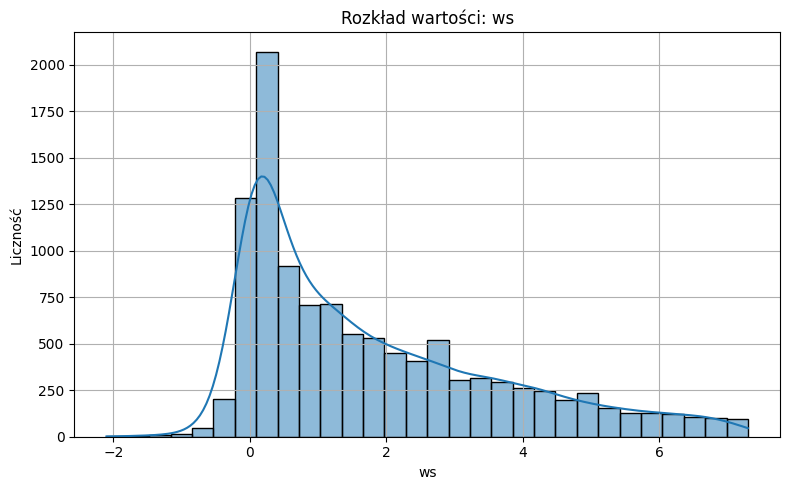

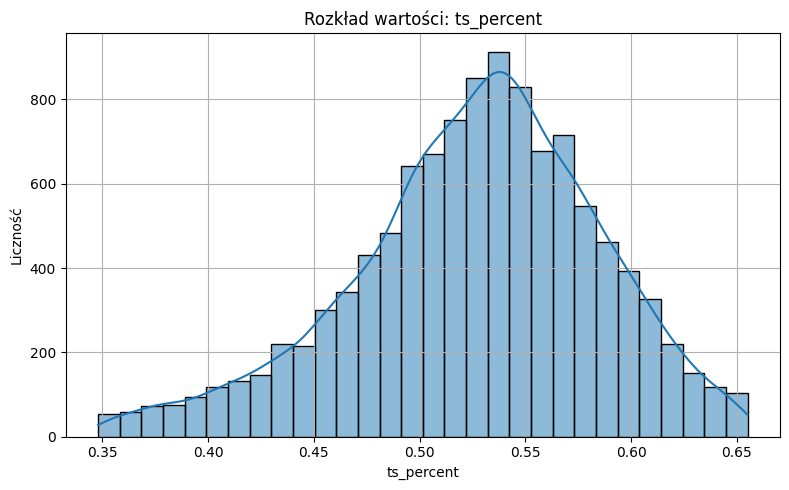

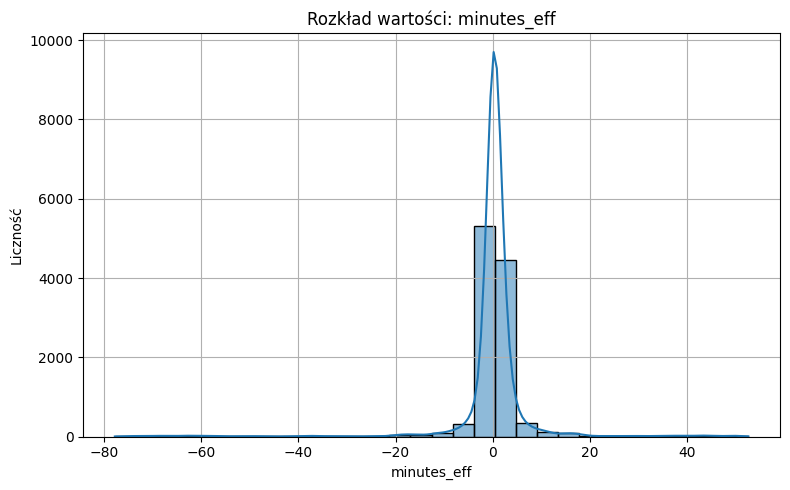

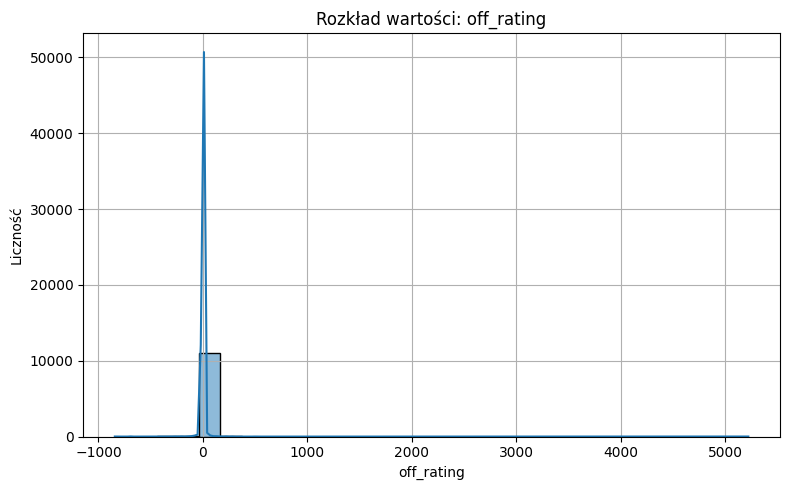

In [ ]:
# 11.1 Konwersja wyników do pandas
# Konwertuj kluczowe wyniki do pandas DataFrame dla łatwiejszej wizualizacji

# Kod konwersji do pandas

#Przeanalizujemy dane z 20 ostatnich sezonów NBA
recent_df = df_cleaned.filter(col("season") >= 2005)

# Wybór kolumn
columns_to_plot = [
    "player", "season", "pos", "tm", "per", "ws", "ts_percent",
    "minutes_eff", "off_rating", "career_avg_ws"
]

# Konwersja do Pandas
recent_pd = recent_df.select(*columns_to_plot).toPandas()


# 11.2 Wizualizacja trendów
# Stwórz wykresy trendów dla kluczowych metryk

# Kod wizualizacji trendów
# Wizualizacja średniego PER na sezon
plt.figure(figsize=(12, 6))
sns.lineplot(data=recent_pd, x="season", y="per", estimator="mean", ci=None)
plt.title("Średni PER na sezon")
plt.xlabel("Sezon")
plt.ylabel("PER")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11.3 Wizualizacja porównawcza
# Stwórz wykresy porównujące różne segmenty/kategorie

# Kod wizualizacji porównawczej
# Porównanie win shares  dla różnych pozycji  oraz true shooting percent dla drużyn
plt.figure(figsize=(10, 6))
sns.boxplot(data=recent_pd, x="pos", y="ws")
plt.title("Rozkład Win Shares według pozycji")
plt.xlabel("Pozycja")
plt.ylabel("Win Shares")
plt.grid(True)
plt.tight_layout()
plt.show()

top_teams = recent_pd['tm'].value_counts().nlargest(10).index.tolist()
subset = recent_pd[recent_pd['tm'].isin(top_teams)]

plt.figure(figsize=(14, 6))
sns.violinplot(data=subset, x="tm", y="ts_percent")
plt.title("True Shooting % dla 10 najczęstszych drużyn")
plt.xlabel("Drużyna")
plt.ylabel("TS%")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11.4 Wizualizacja rozkładów
# Stwórz wykresy pokazujące rozkłady kluczowych zmiennych

# Kod wizualizacji rozkładów
metrics = ["per", "ws", "ts_percent", "minutes_eff", "off_rating"]

for metric in metrics:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=recent_pd, x=metric, kde=True, bins=30)
    plt.title(f"Rozkład wartości: {metric}")
    plt.xlabel(metric)
    plt.ylabel("Liczność")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Zadanie 12: Wnioski

Na podstawie przeprowadzonych analiz, sformułuj wnioski wynikające z Twoich badań. Wnioski powinny być konkretne, oparte na danych i odnosić się bezpośrednio do wyników Twoich analiz.

### Kluczowe wnioski z analizy
Warto zwrócić uwagę na fakt, że dane po standaryzacji nie są już tymi samymi danymi w kwestii interpretacji. Po standaryzacji mówimy już o tym ile standardowych odchyleń w górę/w dół od średniej ma sezon.

1. **Wniosek dotyczący głównych trendów**: PER oraz TS% wykazują wzrost na przestrzeni lat co wskazuje na co raz wyższą efektywność zawodników oraz rozwój zdolności rzutowej. Są to dość sensowne obserwacje. Istnieje zmienność w win shares na przestrzeni lat - prawdopodobnie jest to zależne od liczby meczów, efektywności drużyn i liczby wybitnych graczy w danych sezonach takich jak: LeBron James lub Wilt Chamberlain. Ekstremalne zmiany w YoY oznaczają pewne anomalie sezonowe np. Sezon 2020 w którym gra odbywała się w tzw. Bańce w trakcie pandemii. Najbardziej użytecznym wsaźnikiem efektywności można określić TS% ponieważ okazał najmniejsze zmiany na przestrzeni lat.

2. **Wniosek dotyczący segmentacji**: Segmentacja oddaje rzeczywiste realia ligowe. Najwięcej zawodników zostało zaklasyfikowanych jako Role-Player, potem Rookie a na końcu Star. Gwiazdy mają najwyższe średnie PER i WS - bardzo mocno różnią się od innych segmentów. Średnie doświadczenie w lidzę jest nieco wyższe niż Role-Player. Rookie mają najniższe średnie PER i WS. To raczej naturalna kolej rzeczy - pierwszoroczniacy grają mało minut oraz dopiero z czasem adaptują się do poziomu ligii.
3. **Wniosek dotyczący korelacji i zależności**: Najlepiej skorelowane ze sobą są: trb_percent_scaled z drb_percent_scaled oraz orb_percent scaled co jest naturalnym zjawiskiem. Wysokie korelacje można zauważyć także przy mp_scaled oraz g_scaled, experiance_scaled z age_scaled oraz ws_scaled z ows_scaled.

4. **Wniosek dotyczący anomalii**: Dane są wysokiej jakości - wykazano tylko 5 anomalii na cały zbiór czyli 0.02%. Zidentyfikowane anomalie to po prostu wysokie wartości (czas gry >3500 minut).


5. **Wniosek dotyczący wydajności**: Najlepszym podejściem okazało się DataFrameAPI, natomiast bardzo blisko był Spark SQL. RDD API okazało się dość mierne i to pierwsze dwa podejścia są warte używania.

### Ograniczenia analizy

- **Ograniczenia danych**: nie wszystkie zaawansowane statystyki były rejestrowane od początku trwania ligi, co może niekorzystnie wpływać na pewnego rodzaju wiarygodność analizy. Problemem także jest brak kontekstu pozastatystycznego, takiego jak: kontuzje, taktyka trenera, wpływ otoczenia.
- **Ograniczenia metodologiczne**: zbiór danych zawiera informacje tylko "z sezonu na sezon", co może być problematyczne w ocenie efektywności zawodników np. przed i po przerwie na All-Star Game. Ciężko również oceniać zawodników w trakcie meczu. Statystki są analizowane również bez korekty na liczbę posiadanych piłek. Jeżeli tempo meczu jest niższe to wpływa to na zachowanie statystyk.
- **Ograniczenia interpretacyjne**: Brak przyczynowości. Niepełny obraz gracza - statystyki zaawansowane nie oddają w pełni jakości zawodnika. Ekstremalne wartości mogą zniekształcać obserwacje i błędnie sugerować trendy.


## Podsumowanie projektu

W tym projekcie przeprowadziłem kompleksową analizę datasetu NBA Stats 1947 - present (Advanced.csv) przy użyciu PySpark. Główne osiągnięcia projektu obejmują:

- **Wstępna obróbka danych**  
  Wczytano zbiór `advanced.csv` (statystyki NBA 1947–2025). Wykonano konwersję typów numerycznych, uzupełnianie braków, usunięcie duplikatów oraz eliminację wartości odstających (metoda IQR).

- **Zaawansowany preprocessing**  
  Zbudowano pipeline z niestandardowymi transformerami (`ColumnScaler`, `FeatureEngineer`) do skalowania danych i tworzenia nowych zmiennych (`minutes_eff`, `off_rating`, `career_avg_ws`). Zakodowano zmienne kategoryczne (pozycja, zespół).

- **Eksploracyjna analiza danych (EDA)**  
  Obliczono statystyki opisowe i rozkłady zmiennych, miary asymetrii i kurtozy. Zidentyfikowano silne korelacje między zmiennymi (`PER`, `WS`, `TS%`) i przedstawiono je w formie macierzy korelacji.

- **Analiza grupowa**  
  Przeanalizowano średnie wartości `PER`, `WS`, `TS%`, `BPM` i `VORP` w podziale na pozycje graczy, zespoły oraz grupy doświadczenia (`rookie`, `young`, `prime`, `veteran`).

- **Analiza trendów czasowych**  
  Wykonano analizę sezonową wskaźników `PER`, `WS` i `TS%` z lat 1947–2025. Obliczono zmiany rok-do-roku (YoY) z użyciem funkcji okienkowych (`lag`).

- **Segmentacja graczy**  
  Stworzono segmentację graczy na podstawie doświadczenia, `PER` i `WS` do klas: `rookie`, `role_player`, `star`. Przeanalizowano liczność i charakterystyki segmentów.

- **Ranking graczy w ramach sezonów**  
  Zastosowano funkcje `rank()` i `percent_rank()` do uszeregowania graczy w ramach sezonów według wskaźnika `WS`.


Projekt ten pokazał, jak PySpark może być wykorzystany do efektywnej analizy dużych zbiorów danych i generowania wartościowych wniosków biznesowych.